In [2]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/ssd-utils/
%cd ssd-utils

Cloning into 'ssd-utils'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), 13.63 KiB | 1.95 MiB/s, done.
/home/pedro/Documents/experimental_dl/ssd-utils/ssd-utils


In [3]:
from torch_snippets import *
DATA_ROOT = '../open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = pd.read_csv(f'{DATA_ROOT}/df.csv')
df = DF_RAW.copy()

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [4]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
denormalize = transforms.Normalize(
                mean=[-0.485/0.229,-0.456/0.224,-0.406/0.255],
                std=[1/0.229, 1/0.224, 1/0.255]
            )


def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
    
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), \
                       resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to 
        # absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor( \
                        image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] \
                    for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

In [5]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), \
                             test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], \
                df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, \
                          collate_fn=train_ds.collate_fn, \
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, \
                         collate_fn=test_ds.collate_fn, \
                         drop_last=True)


2020-12-20 13:32:34.144 | INFO     | __main__:__init__:26 - 13702 items loaded
2020-12-20 13:32:34.164 | INFO     | __main__:__init__:26 - 1523 items loaded


In [6]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
    
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [7]:
from model import SSD300, MultiBoxLoss
from detect import *

In [8]:
n_epochs = 5

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, \
                              weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, \
                         device=device)

log = Report(n_epochs=n_epochs)
logs_to_print = 5


Loaded base model.



/home/pedro/anaconda3/envs/science/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [9]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss = train_batch(inputs, model, criterion, \
                            optimizer)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), end='\r')

EPOCH: 5.000	val_loss: 2.054	(1610.17s - 0.00s remaining)))))

In [10]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

2020-12-20 14:00:04.306 | INFO     | torch_snippets.loader:Glob:190 - 15225 files found at ../open-images-bus-trucks//images/*


In [11]:
bbs, labels, scores = detect(original_image, model, \
                             min_score=0.9, max_overlap=0.5,\
                             top_k=200, device=device)

[[137, 79, 255, 139]] ['Truck @ 0.90']


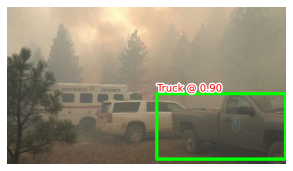

In [12]:
labels = [target2label[c.item()] for c in labels]
label_with_conf = [f'{l} @ {s:.2f}' \
                   for l,s in zip(labels,scores)]
print(bbs, label_with_conf)
show(original_image, bbs=bbs, \
     texts=label_with_conf, text_sz=10)